Epoch 0, Loss: 0.155413, Internal Energy: 0.013431
Epoch 100, Loss: 0.006480, Internal Energy: 0.003464
Epoch 200, Loss: 0.006436, Internal Energy: 0.003395
Epoch 300, Loss: 0.006417, Internal Energy: 0.003383
Epoch 400, Loss: 0.006409, Internal Energy: 0.003377
Epoch 500, Loss: 0.006405, Internal Energy: 0.003375
Epoch 600, Loss: 0.006403, Internal Energy: 0.003374
Epoch 700, Loss: 0.006401, Internal Energy: 0.003372
Epoch 800, Loss: 0.006399, Internal Energy: 0.003371
Epoch 900, Loss: 0.006398, Internal Energy: 0.003370
Epoch 1000, Loss: 0.006397, Internal Energy: 0.003369
Epoch 1100, Loss: 0.006396, Internal Energy: 0.003369
Epoch 1200, Loss: 0.006395, Internal Energy: 0.003368
Epoch 1300, Loss: 0.006394, Internal Energy: 0.003367
Epoch 1400, Loss: 0.006393, Internal Energy: 0.003367
Epoch 1500, Loss: 0.006392, Internal Energy: 0.003366
Epoch 1600, Loss: 0.006392, Internal Energy: 0.003366
Epoch 1700, Loss: 0.006391, Internal Energy: 0.003365
Epoch 1800, Loss: 0.006391, Internal Ene

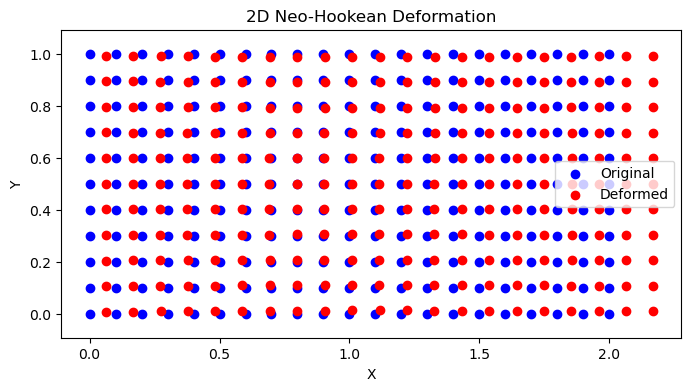

In [2]:
import torch
import torch.nn as nn
import numpy as np

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Material and domain properties
Lx, Ly = 2.0, 1.0  # Beam dimensions
E = 1.0             # Young's modulus
nu = 0.3            # Poisson's ratio
mu = E / (2 * (1 + nu))
lambda_ = E * nu / ((1 + nu) * (1 - 2 * nu))  # Lame constants
force_right = 0.2  # 均匀分布的力大小


def create_domain(nx, ny):
    """Creates the computational domain as a grid of points."""
    x = torch.linspace(0, Lx, nx)
    y = torch.linspace(0, Ly, ny)
    xv, yv = torch.meshgrid(x, y, indexing="ij")
    points = torch.cat([xv.reshape(-1, 1), yv.reshape(-1, 1)], dim=1).to(device)
    return points

def compute_deformation_gradient(points, displacements):
    """Compute deformation gradient F."""
    du_dx = torch.autograd.grad(
        displacements[:, 0].sum(), points, create_graph=True, retain_graph=True
    )[0]
    du_dy = torch.autograd.grad(
        displacements[:, 1].sum(), points, create_graph=True, retain_graph=True
    )[0]
    F = torch.zeros(points.shape[0], 2, 2, device=device)
    F[:, 0, 0] = 1 + du_dx[:, 0]
    F[:, 0, 1] = du_dx[:, 1]
    F[:, 1, 0] = du_dy[:, 0]
    F[:, 1, 1] = 1 + du_dy[:, 1]
    return F

def neo_hookean_energy(F):
    """Compute Neo-Hookean strain energy."""
    C = F.transpose(-1, -2) @ F  # Right Cauchy-Green deformation tensor
    J = torch.det(F)  # Determinant of F
    I1 = torch.diagonal(C, dim1=-2, dim2=-1).sum(-1)  # Trace of C
    psi = 0.5 * mu * (I1 - 2 - 2 * torch.log(J)) + 0.5 * lambda_ * (torch.log(J) ** 2)
    return psi

class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NeuralNetwork, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.network(x)

def train_model(points, model, optimizer, num_epochs, dx, dy):
    """Train the DEM model."""
    for epoch in range(num_epochs):
        optimizer.zero_grad()

        # Predict displacements
        displacements = model(points)

        # Compute deformation gradient and strain energy
        F = compute_deformation_gradient(points, displacements)
        energy_density = neo_hookean_energy(F)

        # Internal energy loss
        internal_energy = (energy_density * dx * dy).sum()

        # Apply boundary conditions (Dirichlet)
        boundary_loss = 0.0
        left_mask = points[:, 0] == 0
        right_mask = points[:, 0] == Lx
        
        # Left boundary fixed
        boundary_loss += nn.MSELoss()(displacements[left_mask], torch.zeros_like(displacements[left_mask]))

        traction_loss = displacements[right_mask][:, 0]  # 取右边界的 x 方向位移
        applied_force = torch.ones_like(traction_loss) * force_right
        boundary_loss += nn.MSELoss()(traction_loss, applied_force)

        # Total loss
        loss = internal_energy + boundary_loss
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.6f}, Internal Energy: {internal_energy.item():.6f}")

    return model

# Hyperparameters
nx, ny = 21, 11  # Grid resolution
hidden_dim = 64
num_epochs = 2000
learning_rate = 1e-3

# Create computational domain
points = create_domain(nx, ny)
points.requires_grad_(True)

dx, dy = Lx / (nx - 1), Ly / (ny - 1)

# Initialize model and optimizer
model = NeuralNetwork(2, hidden_dim, 2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
trained_model = train_model(points, model, optimizer, num_epochs, dx, dy)

# Visualize results
with torch.no_grad():
    displacements = trained_model(points)
    x_deformed = points[:, 0] + displacements[:, 0]
    y_deformed = points[:, 1] + displacements[:, 1]

    import matplotlib.pyplot as plt
    plt.figure(figsize=(8, 4))
    plt.scatter(points[:, 0].cpu(), points[:, 1].cpu(), color='blue', label='Original')
    plt.scatter(x_deformed.cpu(), y_deformed.cpu(), color='red', label='Deformed')
    plt.legend()
    plt.title("2D Neo-Hookean Deformation")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.axis("equal")
    plt.show()
